[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxiLechner/neural-quantum-states/blob/master/notebooks/colab.ipynb)

## Ground state of the 1d Ising/Heisenberg/J1J2 model with autoregressive neural quantum states

Representing ground states of 1d Hamiltonians using neural networks with the help of [Jax](https://github.com/google/jax) and [Flax](https://github.com/google/flax).

This code is best run on a GPU. The simplest way to try out this program is to click on the colab link at the very top. If you instead want to run it locally using only your cpu then you further need to run the following code.

In [ ]:
# !pip install --upgrade pip
# !pip install --upgrade jax jaxlib

If you also want to use your own nvidia gpu then you need to instead follow the detailed installation instructions for jax which can be found [here](https://github.com/google/jax/blob/master/README.md#installation).

In [ ]:
!pip install -q flax
!pip install -q git+https://www.github.com/MaxiLechner/neural-quantum-states#egg=nqs

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Plotting

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 6.4 * 1.5, 4.8 * 1.5
rcParams['lines.linewidth'] = 1.5
plt.style.use('ggplot')

In [3]:
from nqs.hamiltonian import initialize_model_1d

import jax
import jax.numpy as jnp

from jax.experimental import optimizers

import numpy as onp
from time import time
from pathlib import Path
import warnings
from absl import app, flags

In [4]:
def plot(E, mag, E_var, gs_energy):
    fig, ax = plt.subplots(1,2,figsize=(6.4 * 2.5, 4.8 * 1.5))

    ax[0].plot(E, label='energy')
    ax[0].axhline(gs_energy, label='exact energy',linestyle=':', color="r")
    ax[0].plot(mag, label='magnetization')
    ax[0].axhline(0, label='exact magnetization',linestyle=':', color="b")
    

    ax[1].semilogy(E_var, label='Energy variance') 

    ax[0].set_ylabel('Energy variance', fontsize = 20)
    ax[1].set_ylabel('Energy variance', fontsize = 20)
    ax[0].set_xlabel(r'Training step', fontsize = 20)
    ax[1].set_xlabel(r'Training step', fontsize = 20)
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

## Parameters

In [5]:
pbc = False # use periodic boundary conditions of pbc==True else use open boundary conditions
one_hot = False # use one_hot encoding or not, e.g spins are represented by -1,1 or (1,0),(0,1)

hamiltonian = "J1J2_1d" # "heisenberg_1d" | "ising_1d" | "J1J2_1d"
J = 1.0 # nearest neighbor coupling parameter
J2 = 0.2 # next nearest neighbor coupling parameter, only used for J1J2 model

epochs = 5000 #number of iterations
lr = 5e-04 # learning rate for gradient decent
print_every = 200

network = "lstm" # "conv" | "lstm"
batch_size = 50
num_spins = 10
seed = 0 # random seed
depth = 1 # depth of network, note that the runtime of the convnet scales exponentially with depth!
width = 32 # width/number of channels of convolution
filter_size = 5 # filter_size of convolution
hidden_size = 50 # hidden size of lstm

# exact ground state energies for specific hamiltonian and parameter configs
if hamiltonian == "heisenberg_1d":
    if pbc:
        if J == 1:
            gs_energy = num_spins * (1 / 4 - onp.log(2))
        elif J < 0:
            gs_energy = J * num_spins / 4
    elif not pbc and num_spins == 16:
        gs_energy = -6.9117371455749
    else:
        gs_energy = onp.nan

elif hamiltonian == "ising_1d":
    if pbc is False:
        gs_energy = 1 - 1 / (onp.sin(onp.pi / (2 * (2 * num_spins + 1))))
    else:
        gs_energy = onp.nan
        
elif hamiltonian == "J1J2_1d" and num_spins == 10 and J == 1. and J2 == 0.2 and pbc is False:
    gs_energy = -3.9855798336170905

## Compute the groundstate

In [6]:
# set up the simulation
step, key, energy_fn, init_batch, optimizer = initialize_model_1d(hamiltonian,width,filter_size,seed,num_spins,lr,J,J2,batch_size,hidden_size,depth,pbc,network,one_hot=one_hot)

E = []
mag = []
E_var = []
learning_rate = []

def sqrt_decay(init,i):
    return init/jnp.sqrt(1 + 0.001*i)

/Users/Maxi/miniconda3/envs/jax/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [7]:
old_time = time()
for i in range(epochs):
    optimizer, key, energy, magnetization, var = step(optimizer, key, lr, init_batch)
    
    E.append(energy)
    mag.append(magnetization)
    E_var.append(var)
    learning_rate.append(lr)
    if i == 1000:
        lr = 1e-04
    if i == 2000:
        lr = 5e-05
    if i == 3000:
        lr = 1e-05
        
    if i == 1:
        new_time = time()
        print("{}\t{}\t{}\t{}\t{}".format("Step","Energy","Mag","Var","Time/Step"))
        print("-----------------------------------------")
        print("{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}".format(i, energy.real.mean(), magnetization, var.real, new_time - old_time))
        old_time = new_time
    if i % print_every == 0 and i > 0 or i == epochs-1:
        new_time = time()
        print("{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}".format(i, energy.real.mean(), magnetization, var.real, new_time - old_time))
        old_time = new_time


# Compute the mean of the energy +- the standard deviation by averaging over the last k steps.
k = 100 
mean = onp.mean([i.real for i in E[-k:]])
var = onp.sqrt(onp.max(E_var[-k:])/(batch_size*k))
print("Ground state energy = ", mean, '+-', var)
print("Exact energy        = ", gs_energy)
print("Relative Difference = ", onp.abs(mean-gs_energy)/onp.abs(gs_energy))

Step	Energy	Mag	Var	Time/Step
-----------------------------------------
1	-2.17	1.32	2.204	35.98
200	-3.34	0.56	0.545	6.56
400	-3.92	0.00	0.153	7.30
600	-3.89	0.08	0.037	7.62
800	-3.98	-0.04	0.004	7.30
1000	-3.98	0.04	0.005	7.68
1200	-3.97	-0.04	0.013	8.47
1400	-3.99	0.00	0.000	8.11
1600	-3.99	0.00	0.000	9.59
1800	-3.99	0.00	0.000	8.43
2000	-3.98	0.00	0.000	8.79
2200	-3.98	0.00	0.000	10.29
2400	-3.99	0.00	0.001	7.69
2600	-3.98	0.00	0.000	7.52
2800	-3.99	0.00	0.000	8.97
3000	-3.98	0.00	0.000	7.67
3200	-3.99	0.00	0.000	8.04
3400	-3.97	-0.04	0.010	7.97
3600	-3.99	0.00	0.001	7.81
3800	-3.99	0.00	0.000	7.68
4000	-3.98	0.00	0.000	7.14
4200	-3.99	0.00	0.000	8.22
4400	-3.98	0.00	0.000	10.46
4600	-3.99	0.00	0.000	8.44
4800	-3.99	0.00	0.000	8.58
4999	-3.98	0.00	0.000	9.29
Ground state energy =  -3.9827707 +- 0.0015161472507178827
Exact energy        =  -3.9855798336170905
Relative Difference =  0.0007048289968176185


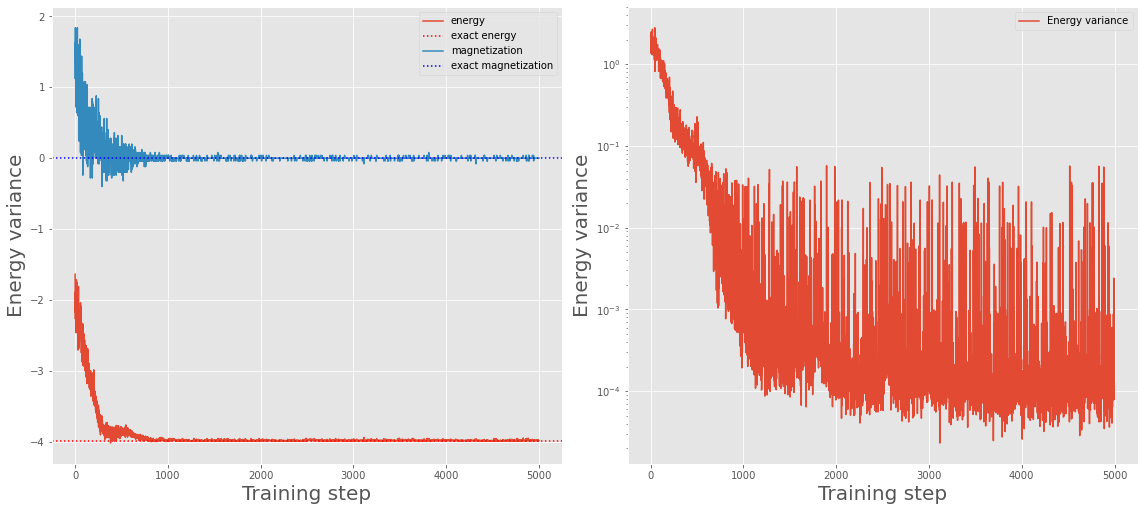

In [8]:
plot(E, mag, E_var, gs_energy)